https://sandipanweb.wordpress.com/2018/02/25/implementing-lucas-kanade-optical-flow-algorithm-in-python/

https://www.youtube.com/watch?v=kJouUVZ0QqU

In [2]:
import numpy as np
import cv2 as cv
from skimage import io
from matplotlib import pyplot as plt
from scipy import signal
import sklearn
from sklearn.preprocessing import scale,normalize

In [3]:
def url_to_image(url):
    print("downloading %s" % (url))
    image = io.imread(url)
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def cv2_imshow(img):
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
    plt.axis("off")
    plt.show()
    
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v002.jpg


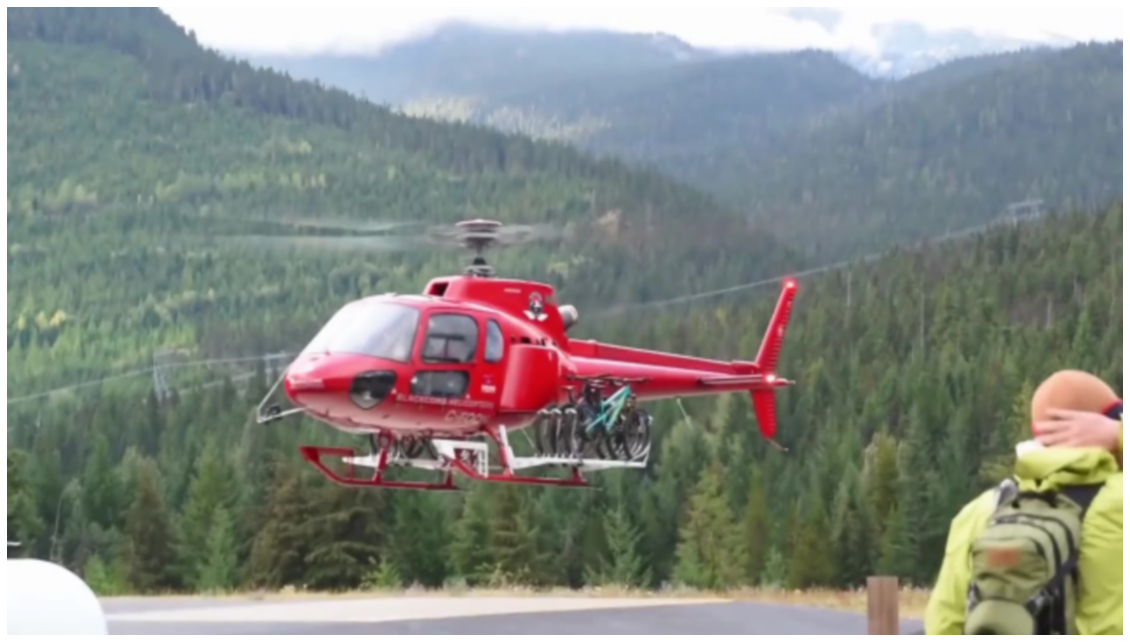

downloading https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v003.jpg


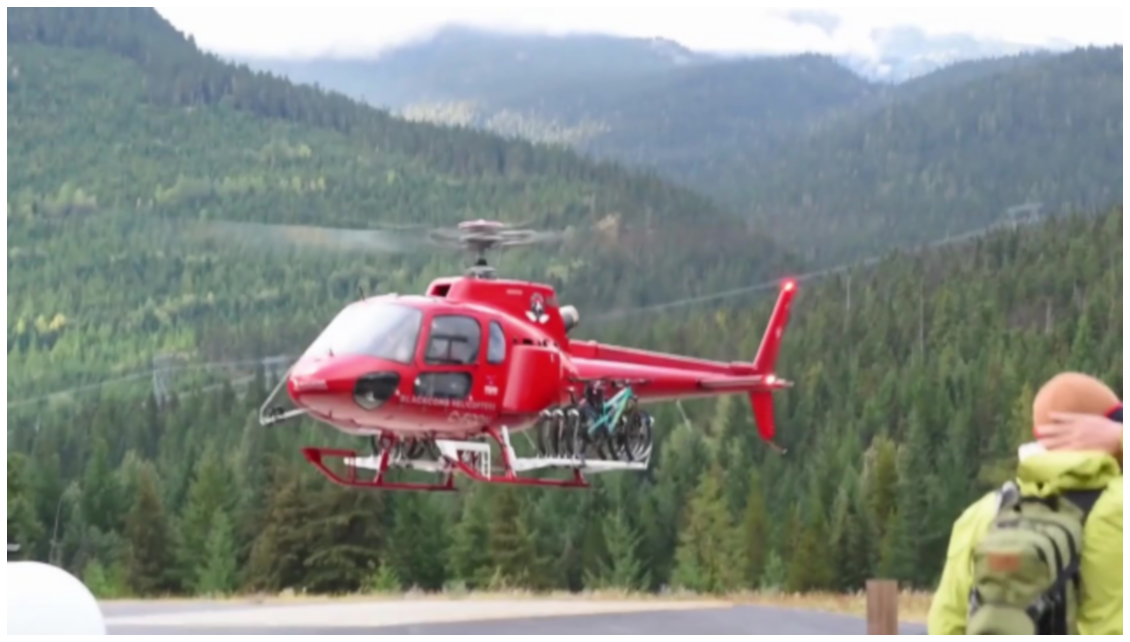

In [4]:
resize = 0.5
img1 = url_to_image('https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v002.jpg')
img1 = cv.resize(img1,None,fx=resize,fy=resize)
cv2_imshow(cv.cvtColor(img1, cv.COLOR_RGB2BGR))
img2 = url_to_image('https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/frames/v003.jpg')
img2 = cv.resize(img2,None,fx=resize,fy=resize)
cv2_imshow(cv.cvtColor(img2, cv.COLOR_RGB2BGR))

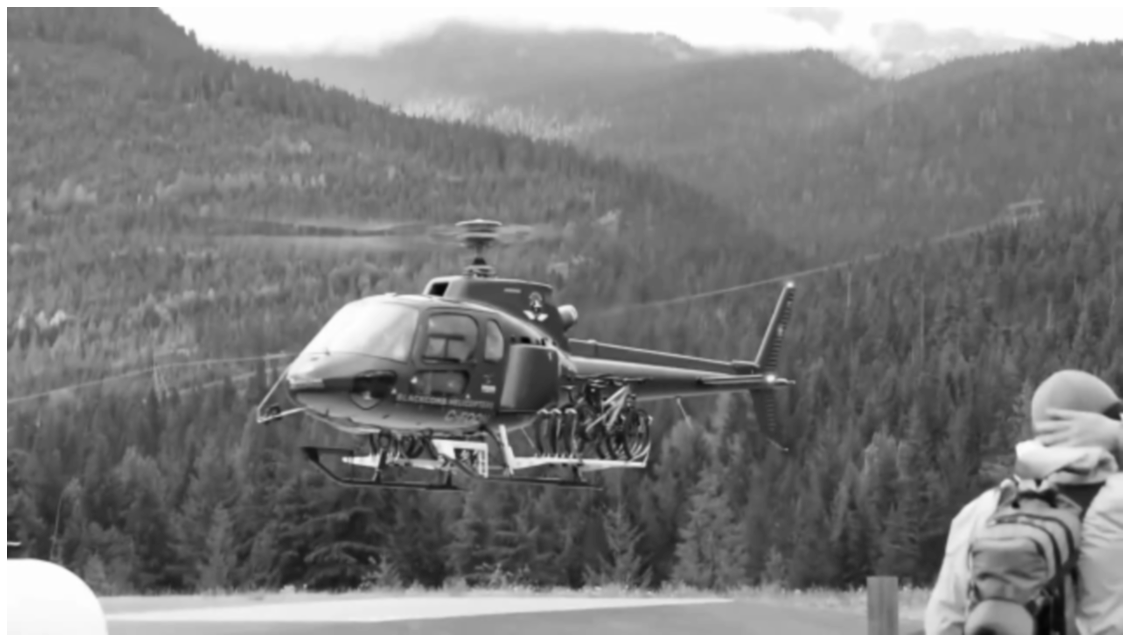

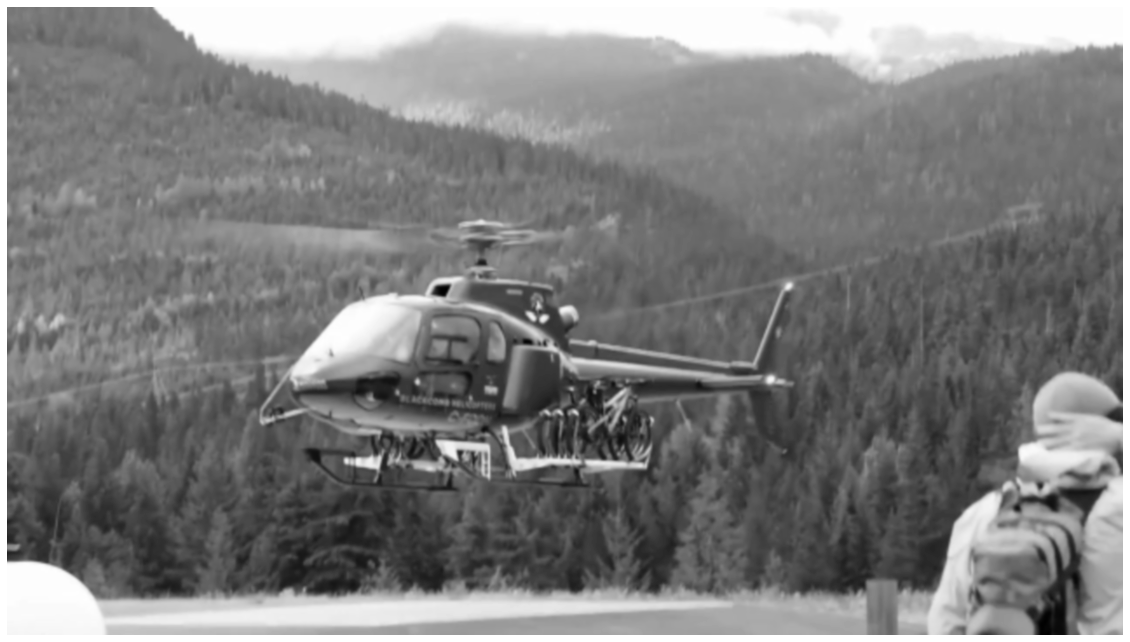

In [5]:
gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
cv2_imshow(gray1)
gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
cv2_imshow(gray2)

In [6]:
kernel_x = np.array([
    [1,0,-1],
    [2,0,-2],
    [1,0,-1]
])
kernel_y = np.array([
    [1,2,1],
    [0,0,0], 
    [-1,-2,-1]
])

image1 = normalize(gray1) 
image2 = normalize(gray2)

# image1 = gray1 / 255.
# image2 = gray2 / 255.

dfx = signal.convolve2d(image1, kernel_x, boundary='symm', mode='same')
dfy = signal.convolve2d(image1, kernel_y, boundary='symm', mode='same')
dt = np.subtract(image2, image1)

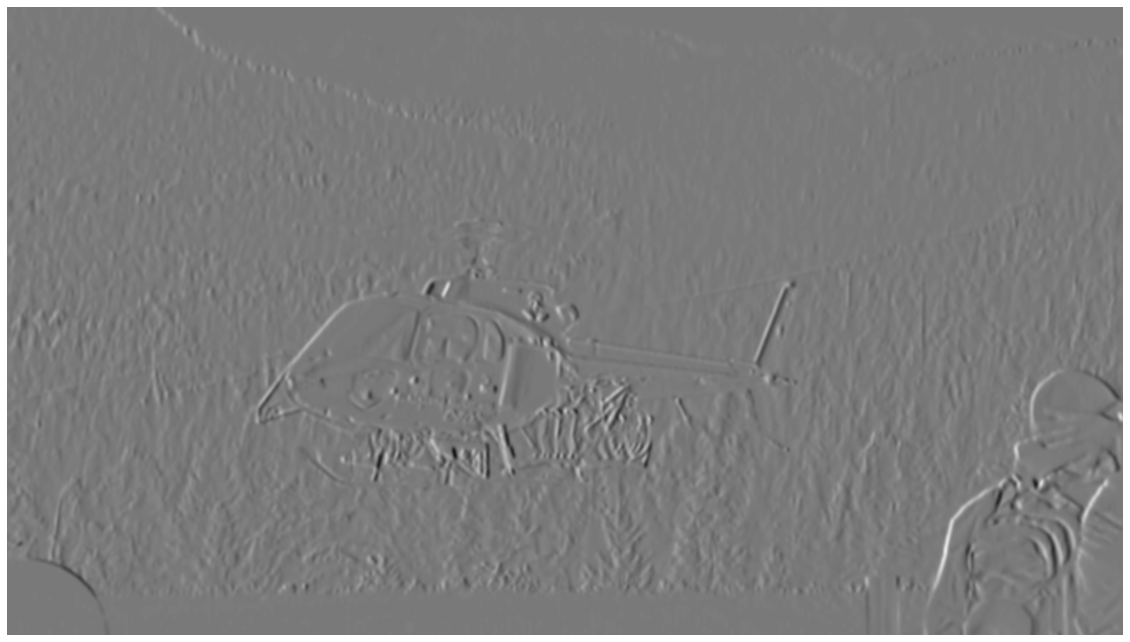

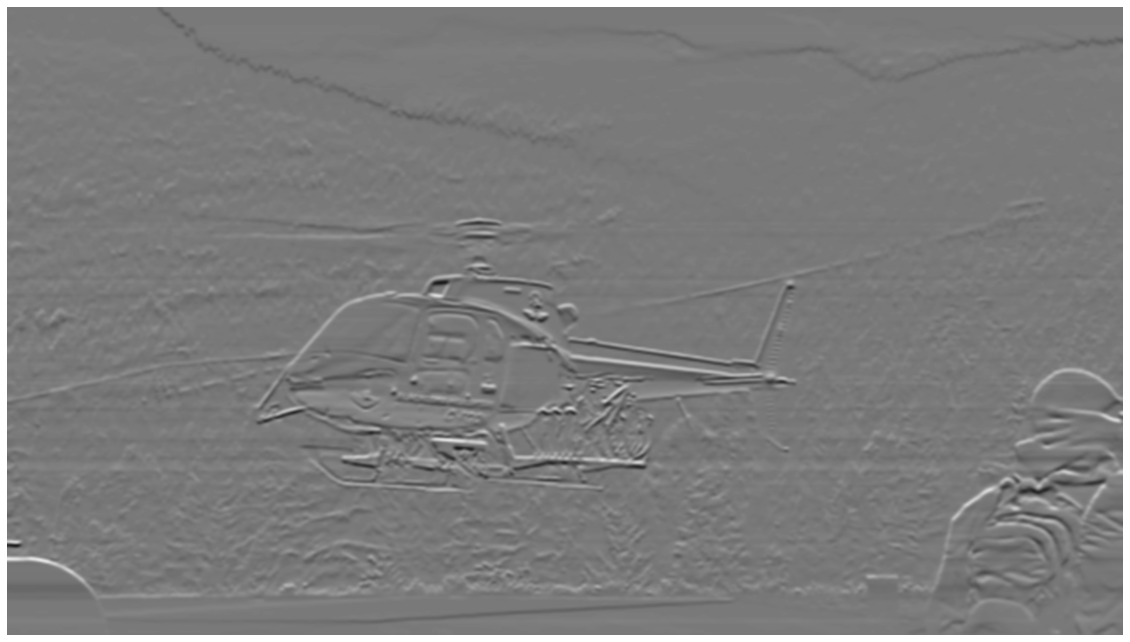

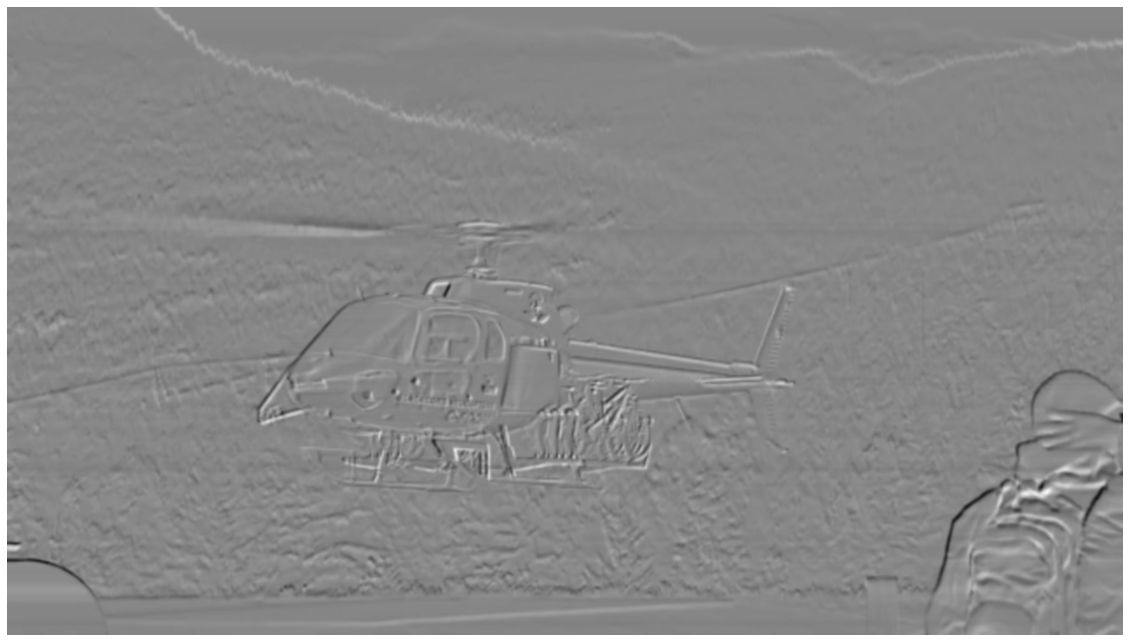

In [7]:
cv2_imshow(dfx)
cv2_imshow(dfy)
cv2_imshow(dt)

In [68]:
def lc(dfx, dfy, dt, w = 3):
    u = np.zeros(dfx.shape)
    v = np.zeros(dfx.shape)

    for i in range(w, dfx.shape[0]-w):
        for j in range(w, dfx.shape[1]-w):
            window_dfx = dfx[i-w:i+w+1, j-w:j+w+1].flatten()
            window_dfy = dfy[i-w:i+w+1, j-w:j+w+1].flatten()
            window_dt = dt[i-w:i+w+1, j-w:j+w+1].flatten()

            A = np.array([
                [np.sum(np.multiply(window_dfx,window_dfx)), np.sum(np.multiply(window_dfx,window_dfy))],
                [np.sum(np.multiply(window_dfx,window_dfy)), np.sum(np.multiply(window_dfy,window_dfy))],
            ])

            B = np.array([
                [A[1,1], -1*A[0,1]],
                [-1*A[1,0], A[0,0]]
            ])
            c = 0 if (A[0,0] * A[1,1] - A[0,1] * A[1,0]) == 0 else 1 / (A[0,0] * A[1,1] - A[0,1] * A[1,0])
            A_inv = c * B

            f = [
                np.negative(np.sum(np.multiply(window_dfx,window_dt))),
                np.negative(np.sum(np.multiply(window_dfy,window_dt)))
            ]
            nu = A_inv.dot(f)

            u[i,j]=nu[0]
            v[i,j]=nu[1]
            
    flow = np.zeros((u.shape[0], u.shape[1], 2))
    flow[:,:,0] = u
    flow[:,:,1] = v
            
    return flow

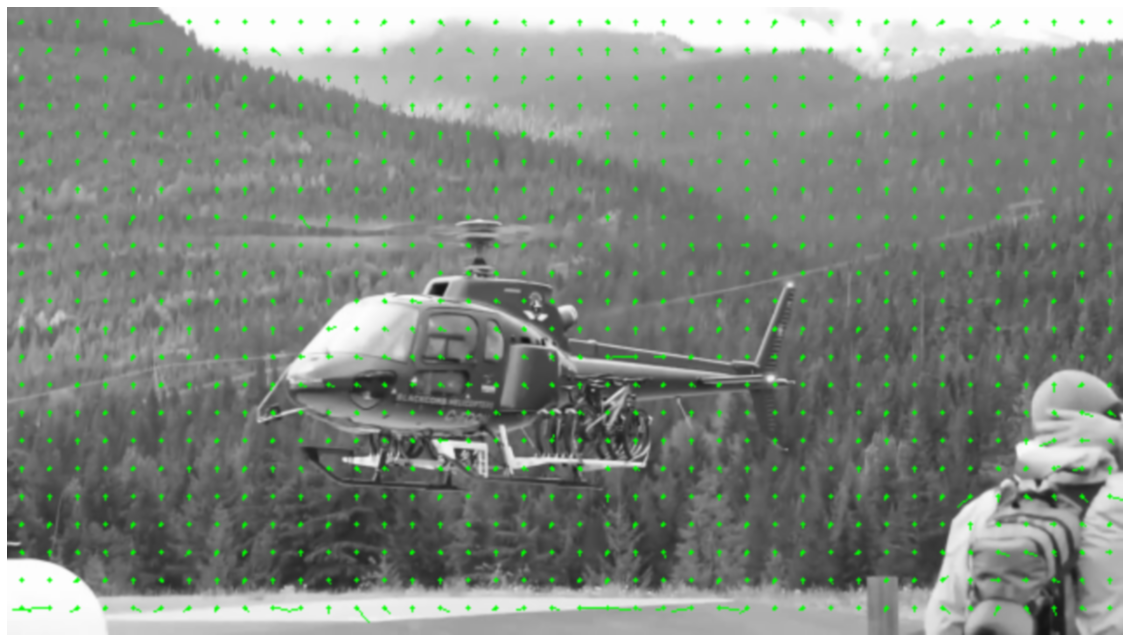

In [10]:
flow = lc(dfx, dfy, dt, w = 3)
flow_img = draw_flow(np.copy(gray1), flow*10)
cv2_imshow(flow_img)



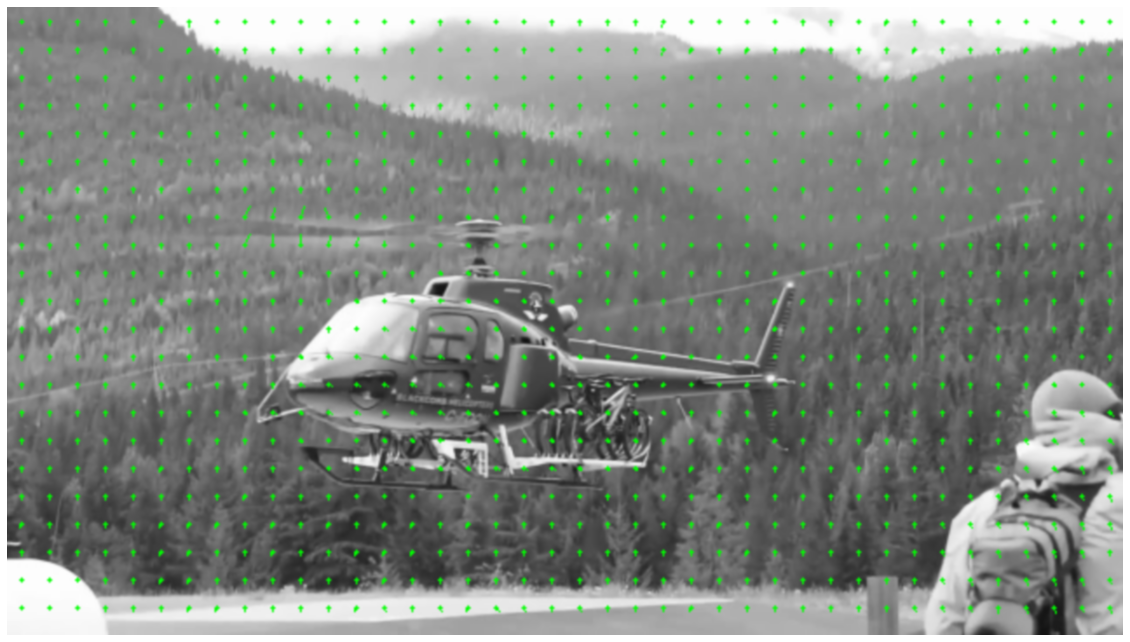

In [31]:
flow = cv.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
flow_img = draw_flow(np.copy(gray1), flow)
cv2_imshow(flow_img)

### Image pyramid

In [66]:
def bilinear_interpolate(flow):
    # try resize by opencv
    return cv.pyrUp(flow) * 2

def center_mass_change(img, flow):
    new_img = np.zeros(img.shape)
    
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if x+int(flow[x,y,0]) >= img.shape[0] or y+int(flow[x,y,1]) >= img.shape[1]:
                continue
            new_img[x, y] = img[x+int(flow[x,y,0]), y+int(flow[x,y,1])]
            
    return new_img

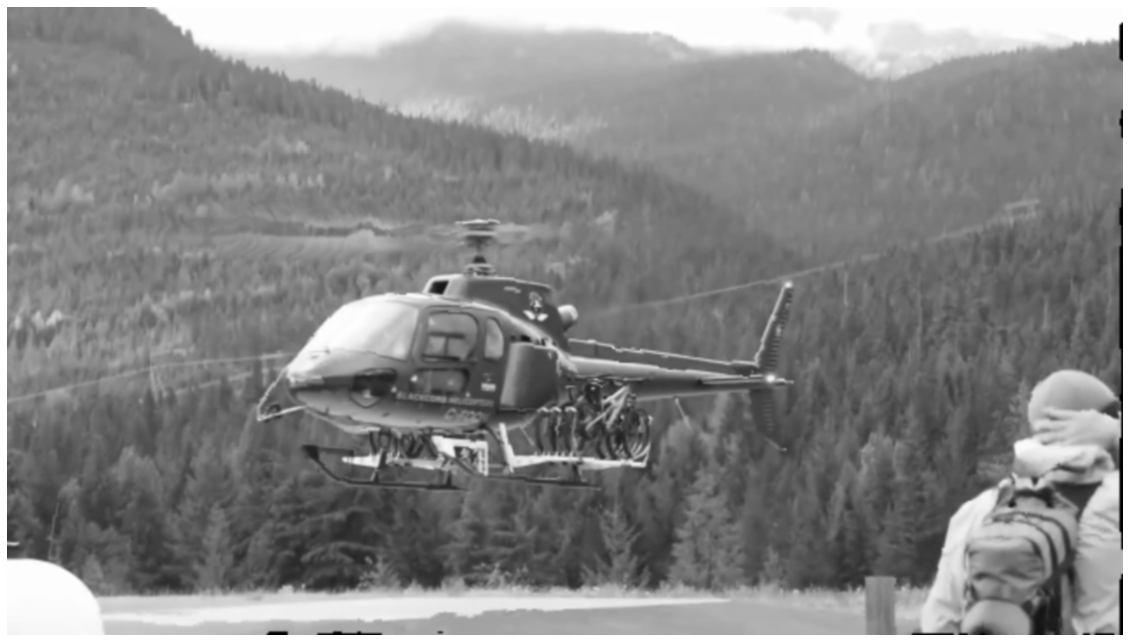

diff gray2 - img3 : 9924
diff gray1 - img3 : 7001
diff gray1 - gray2 : 85063


In [38]:
img3 = center_mass_change(gray1, flow)
cv2_imshow(img3)

print('diff gray2 - img3 : {:.0f}'.format(np.linalg.norm(np.subtract(gray2, img3))))
print('diff gray1 - img3 : {:.0f}'.format(np.linalg.norm(np.subtract(gray1,img3))))
print('diff gray1 - gray2 : {:.0f}'.format(np.linalg.norm(np.subtract(gray1,gray2))))

In [69]:
piramids1 = [gray1]
piramids2 = [gray2]
levels = 3

# fill flows on different levels
for current_level in range(levels-1):
    piramids1.append(cv.pyrDown(piramids1[-1]))  
    piramids2.append(cv.pyrDown(piramids2[-1]))
    
# from smallest to the biggest
piramids1 = np.flip(piramids1)
piramids2 = np.flip(piramids2)

In [91]:
# https://en.wikipedia.org/wiki/Bilinear_interpolation

prev_level_flow = None
for current_level in range(levels):    
    image1 = normalize(piramids1[current_level]) 
    image2 = normalize(piramids2[current_level])
    
    print('current level image shape: {}'.format(image1.shape))
    
    dfx = signal.convolve2d(image1, kernel_x, boundary='symm', mode='same')
    dfy = signal.convolve2d(image1, kernel_y, boundary='symm', mode='same')
    
    if current_level == 0:
        # first run, there is nothing to rescale
        flow_rescaled = np.zeros((dfx.shape[0], dfx.shape[1], 2))
        dt = np.subtract(image2, image1)    
    else:
        flow_rescaled = bilinear_interpolate(prev_level_flow)
        dt = np.subtract(image2, center_mass_change(image1, flow_rescaled))
    
    flow_correction = lc(dfx, dfy, dt, w=5)
    prev_level_flow = np.add(flow_rescaled, flow_correction)
    
flow = prev_level_flow

current level image shape: (90, 160)
current level image shape: (180, 320)
current level image shape: (360, 640)


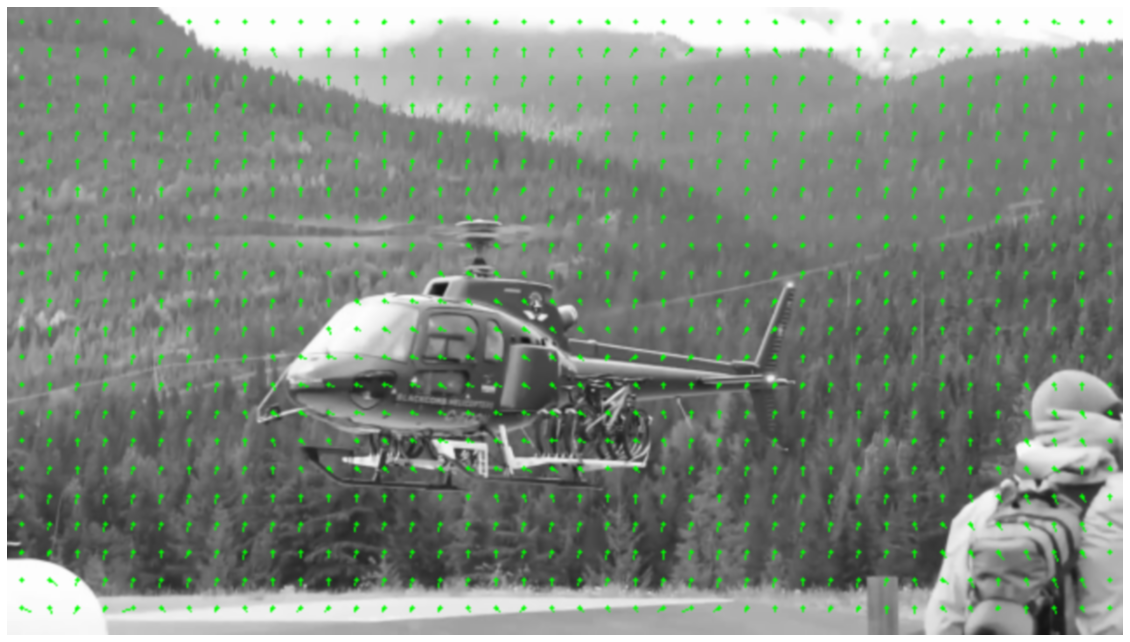

In [108]:
flow_img = draw_flow(np.copy(gray1), flow * 5)
cv2_imshow(flow_img)

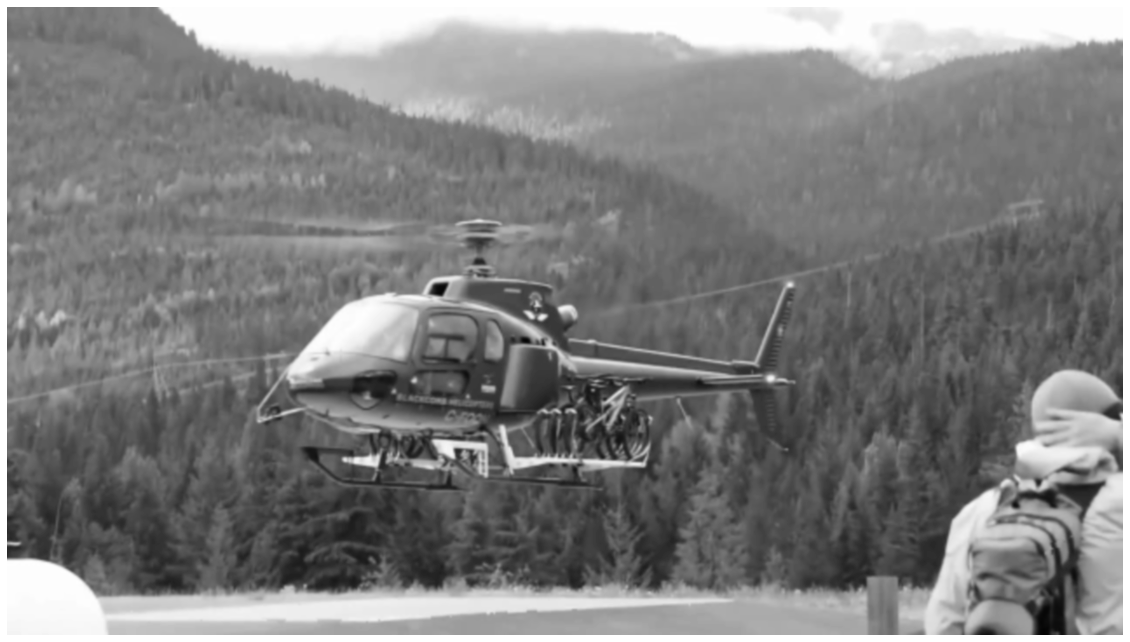

diff gray2 - img3 : 7653
diff gray1 - img3 : 457
diff gray1 - gray2 : 85063


In [93]:
img3 = center_mass_change(gray1, flow)
cv2_imshow(img3)

print('diff gray2 - img3 : {:.0f}'.format(np.linalg.norm(np.subtract(gray2, img3))))
print('diff gray1 - img3 : {:.0f}'.format(np.linalg.norm(np.subtract(gray1,img3))))
print('diff gray1 - gray2 : {:.0f}'.format(np.linalg.norm(np.subtract(gray1,gray2))))

In [106]:
# https://www.pyimagesearch.com/2017/06/19/image-difference-with-opencv-and-python/

from skimage.measure import compare_ssim

print('diff gray2 - img3 : {}'.format(compare_ssim(gray2, img3, full=True)[0]))
print('diff gray1 - img3 : {}'.format(compare_ssim(gray1, img3, full=True)[0]))
print('diff gray1 - gray2 : {}'.format(compare_ssim(gray1, gray2, full=True)[0]))

diff gray2 - img3 : 0.7278203515362378
diff gray1 - img3 : 0.9988298422306368
diff gray1 - gray2 : 0.7285909897573931
